In [1]:
#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data handling
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Machine learning libraries
import sklearn.cross_validation as cv
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import norm, probplot
from sklearn.metrics import r2_score

#set 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

#Data path
path = "data/kc_house_data.csv"

C:\Users\Saleban\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv(path, index_col = False)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# it looks like need to drop ID, date columns, it contributes nothing to our data
data.drop(['id', 'date'], axis= 1, inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# doing some plotting
def plot_diff(d, col):
    d = pd.concat([data['price'], data[col]], axis =1)
    print(type(d))
    f, ax = plt.subplots(figsize = (20,10))
    fig = sns.boxplot(x = data[col], y = data['price'], data = d)
    fig.axis(ymin = 0, ymax = 3000000)
    plt.xticks(rotation = 90)
    plt.show()

<class 'pandas.core.frame.DataFrame'>


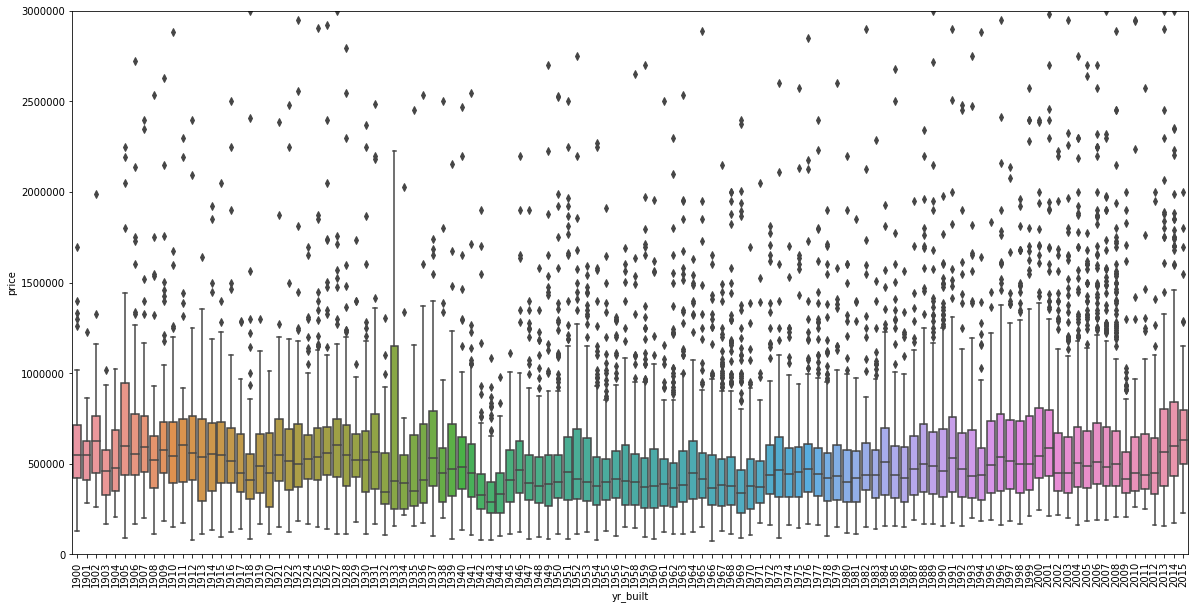

In [5]:
# analyze correlation between Price and Year Built
year = plot_diff(data, 'yr_built')

<class 'pandas.core.frame.DataFrame'>


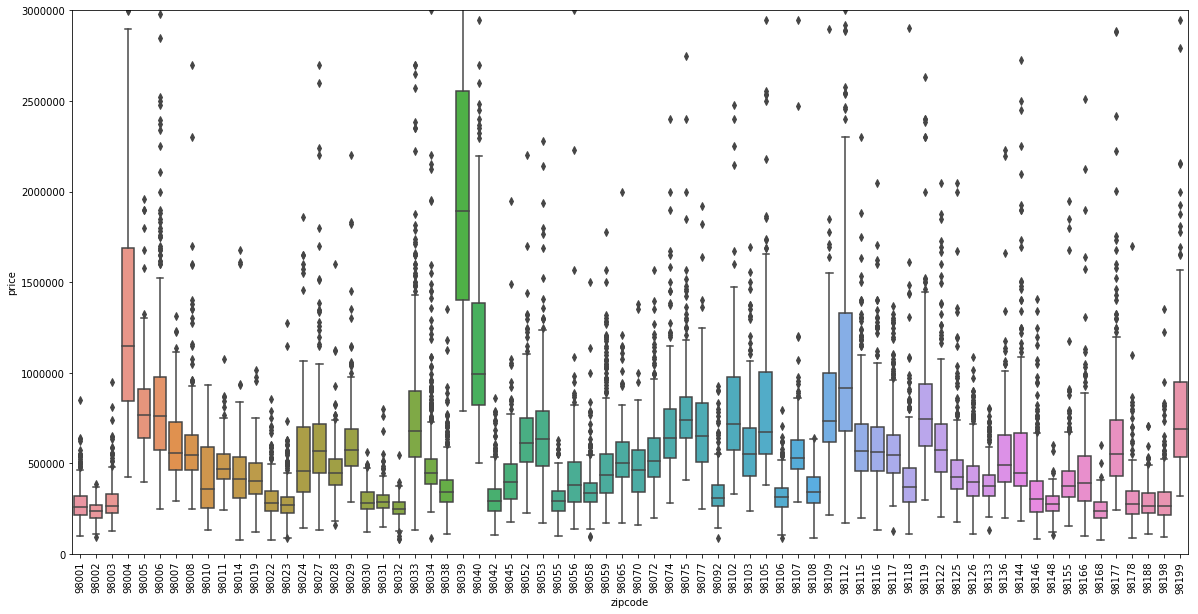

In [6]:
# analyze correlation between Price and zipcode
zipc = plot_diff(data, 'zipcode')

<class 'pandas.core.frame.DataFrame'>


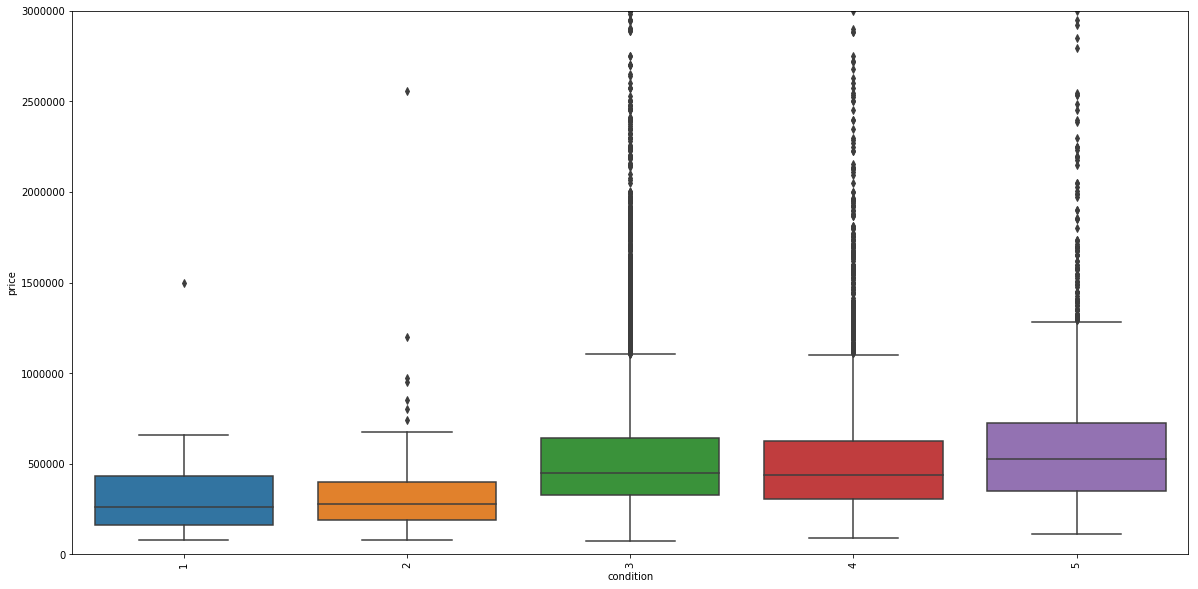

In [7]:
# analyze correlation between Price and condition
cond = plot_diff(data, 'condition')

<class 'pandas.core.frame.DataFrame'>


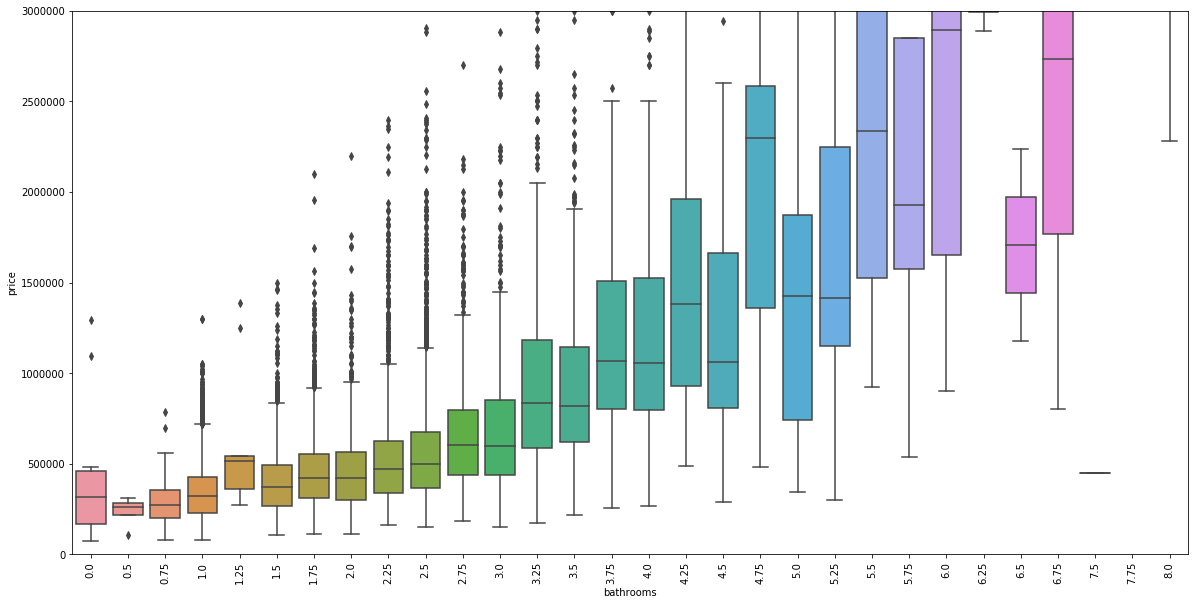

In [8]:
# analyze correlation between Price and Year bathrooms
bath = plot_diff(data, 'bathrooms')

In [9]:
# let's check if our data needs feature scaling
def check_dist(data):
    sns.distplot(data['price'], color='g')
    print("Skewness: %f" %data['price'].skew())
    print("Kurtosis: %f" %data['price'].kurt())

<img style="float: left" src="http://www.janzengroup.net/stats/images/skewkurt.JPG"> </img>

Skewness: 4.024069
Kurtosis: 34.585540


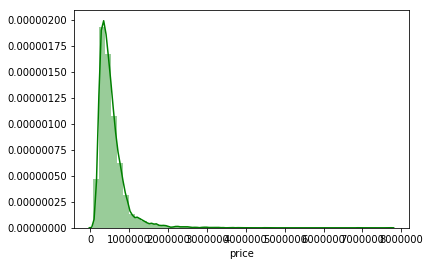

In [10]:
check_dist(data)

In [13]:
# checking correlation matrix
def corr_met(data):
    corrmat = data.corr()
    cols = corrmat.nlargest(15, 'price')['price'].index
    cm = np.corrcoef(data[cols].values.T)
    f, ax = plt.subplots(figsize = (12,9)) #defining figure size
    sns.set(font_scale = 1.25) #font size
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap="YlGnBu")
    plt.show()

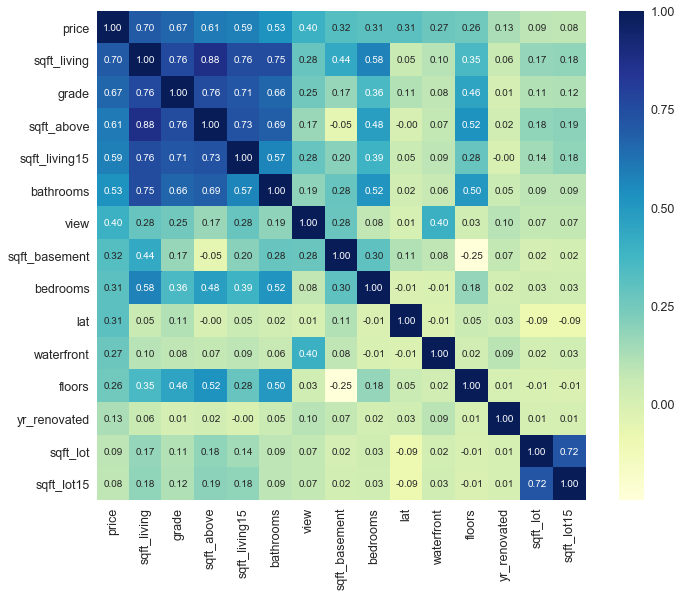

In [14]:
corr_met(data)

In [15]:
corrmat = data.corr()
cols = corrmat.nlargest(15, 'price')['price'].index
data = data[cols]

In [16]:
def graph(data):
    sns.distplot(data, fit = norm, color = 'g')
    fig = plt.figure()

Before normalizing data: 


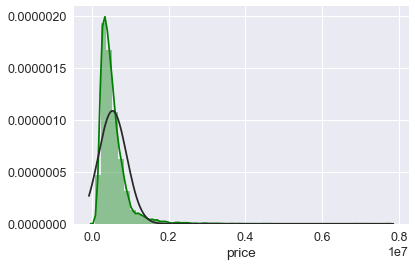

In [17]:
print("Before normalizing data: ")
graph(data['price'])

Plot after normalizing: 


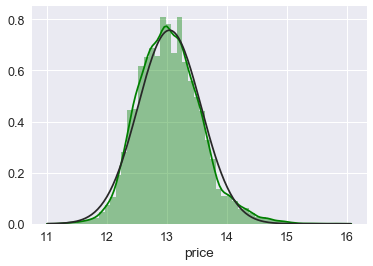

In [18]:
#########
data['price'] = np.log(data['price'])
print("Plot after normalizing: ")
graph(data['price'])

Plot before normalizing: 


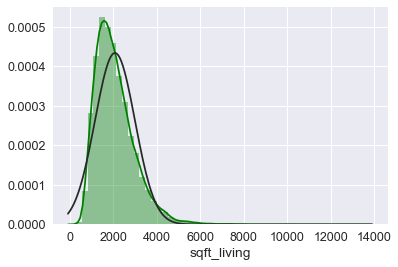

In [19]:
print("Plot before normalizing: ")
graph(data['sqft_living'])

Plot after normalizing: 


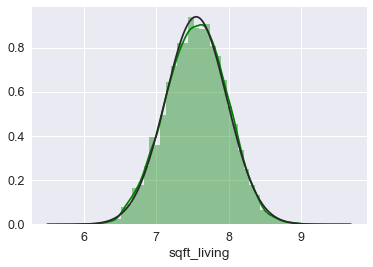

In [20]:

data['sqft_living'] = np.log(data['sqft_living'])
print("Plot after normalizing: ")
graph(data['sqft_living'])

Plot before normalizing: 


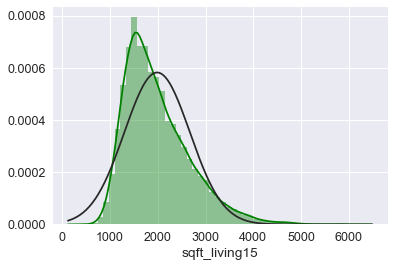

In [21]:
print("Plot before normalizing: ")
graph(data['sqft_living15'])

Plot after normalizing: 


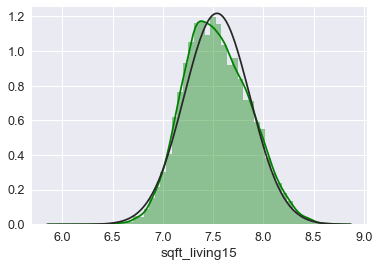

In [22]:
data['sqft_living15'] = np.log(data['sqft_living15'])
print("Plot after normalizing: ")
graph(data['sqft_living15'])

In [23]:
y = data.iloc[:, 0:1]
X = data.iloc[:,:]
X.drop('price', axis = 1, inplace = True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [25]:
# we'll write two functions here, determines our score
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def mse_cv_test(model):
    mse= - cv.cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10)
    return(mse)

def r2_scorer(pred):
    r2 = r2_score(y_test, pred)
    print("R2 Score: %.3f" %r2)

In [26]:
lasso = LassoCV(alphas = [0.001, 0.01, 0.1, 1, 2], max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)
y_test_las = lasso.predict(X_test)
r2_scorer(y_test_las)

Best alpha : 0.001
R2 Score: 0.743


$(True Y) - (Estimated Y) = Error$

$Error^2 = Square Error$

$All(Square Error) / n = MSE$

The mean squared error tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. 

(True Y) - (Estimated Y) = Error

Error ** 2 = Square Error

All(Square Error) / n = MSE

<b>Example...

In [27]:
points = [26,32,29,45,34]
estim = [27.4, 31.5, 27.1, 43.6, 33.2]
y_data = pd.DataFrame({'Y': points})
y_data.head()

es_data = pd.DataFrame({'Estimated':estim})
es_data.head()

#add datas together -> we could use merge, concat, etc.
full_data = y_data.join(es_data)
full_data.head()

,Y,Estimated
0,26,27.4
1,32,31.5
2,29,27.1
3,45,43.6
4,34,33.2


In [28]:
full_data['Error'] = full_data['Y'] - full_data['Estimated']
full_data.head()

,Y,Estimated,Error
0,26,27.4,-1.4
1,32,31.5,0.5
2,29,27.1,1.9
3,45,43.6,1.4
4,34,33.2,0.8


In [29]:
full_data['Error^2'] = full_data['Error']**2
full_data.head()

,Y,Estimated,Error,Error^2
0,26,27.4,-1.4,1.96
1,32,31.5,0.5,0.25
2,29,27.1,1.9,3.61
3,45,43.6,1.4,1.96
4,34,33.2,0.8,0.64


In [30]:
# to find the MSE, we'll add all values in Error-squared and divide by 5
mse_value = np.sum(full_data['Error^2'])/5
print("MSE for this data is: {:.2f}".format(mse_value))

MSE for this data is: 1.68


In [31]:
print("Lasso MSE on Test set : %.3f" %(mse_cv_test(lasso).mean()))

Lasso MSE on Test set : 0.073


In [32]:
#implementing kernel ridge regression
ridge_reg = KernelRidge(kernel = 'linear', gamma = None, degree = None, coef0 = 1, kernel_params = None, alpha = 1)
ridge_reg.fit(X_train, y_train)
ridge_prid = ridge_reg.predict(X_test)
r2_scorer(ridge_prid)

R2 Score: 0.645


In [33]:
print("Linear KRR MSE on Test set : %.3f" %(mse_cv_test(ridge_reg).mean()))

Linear KRR MSE on Test set : 0.100


### Performing GridSearchCV

In [34]:
from sklearn.grid_search import GridSearchCV

C:\Users\Saleban\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
CV_ridge = GridSearchCV(KernelRidge(kernel = 'polynomial', gamma = 1), cv = 10, param_grid = {'degree':[2,5,6]})
CV_ridge.fit(X_train, y_train)
CV_ridge_pred = CV_ridge.predict(X_test)
r2_scorer(CV_ridge_pred = CV_ridge.predict(X_test))

In [ ]:
print("Polynomial KRR MSE on Test set : %.3f" %(mse_cv_test(CV_ridge).mean()))